In [1]:
#important to have the correct version of sklearn 0.23.1 and correct version of joblib 1.2.0
!pip show joblib
!pip show scikit-learn

Name: joblib
Version: 1.2.0
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: 
Required-by: nltk, scikit-learn
Name: scikit-learn
Version: 0.23.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: sagemaker-data-insights, smclarify


In [2]:
!pip install --upgrade scikit-learn==0.23.1


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
#1) Download the movie data sets available in the s3 bucket to the sagemaker notebook environment.
#2) Start analyzing the data

import pandas as pd
import boto3
from sklearn.preprocessing import StandardScaler

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
bucket_name='awesome2023-04272023'

title_basic = 'csv_files/title.basics.tsv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket = bucket_name,Key = title_basic)

df_title_basic = pd.read_table(obj['Body'])
df_title_basic = df_title_basic.dropna()

df_title_basic.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [6]:

# Cleanup steps - Consider only those titles which are movies
title_basics_processed = df_title_basic[df_title_basic['titleType']=='movie']

# Cleanup steps - We dont need end year for this data set
title_basics_processed = title_basics_processed.drop(columns = "endYear")

# Cleanup steps - We dont need titleType since we are only interested in one type of titles
title_basics_processed = title_basics_processed.drop(columns = "titleType" )

#Cleanup steps
values = ['\\N']
#drop rows that contain any value in the list
title_basics_processed = title_basics_processed[title_basics_processed.genres.isin(values) == False]
title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes.isin(values) == False]
title_basics_processed = title_basics_processed[title_basics_processed.startYear.isin(values) == False]

title_basics_processed.head()

,tconst,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,0,1894,45,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,100,"Documentary,News,Sport"
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,0,1907,90,Drama
672,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,120,"Adventure,Fantasy"


In [7]:
# analyze the types of column values , all objects , we will need to convert them to numeric representation as we progress
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375163 entries, 8 to 9811351
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          375163 non-null  object
 1   primaryTitle    375163 non-null  object
 2   originalTitle   375163 non-null  object
 3   isAdult         375163 non-null  object
 4   startYear       375163 non-null  object
 5   runtimeMinutes  375163 non-null  object
 6   genres          375163 non-null  object
dtypes: object(7)
memory usage: 22.9+ MB


In [8]:
#remove some unwanted titles , filter out the rows which are Adult titles
import pandas as pd
title_basics_processed = title_basics_processed[title_basics_processed.isAdult == 0]
title_basics_processed.groupby('isAdult').size()
title_basics_processed = title_basics_processed.drop(columns = "isAdult" )

# Convert the date to numeric value so that you can do some kind of exploratory analysis
title_basics_processed['startYear'] = pd.to_datetime(title_basics_processed['startYear'], format='%Y').dt.year
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1894,45,Romance
144,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897,100,"Documentary,News,Sport"
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama
672,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1908,120,"Adventure,Fantasy"


In [9]:
# Lets see how our tables look now, At this point only date is a numeric column
title_basics_processed.info()

# Find statistics of numeric columns in your dataset
title_basics_processed.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367914 entries, 8 to 9811351
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          367914 non-null  object
 1   primaryTitle    367914 non-null  object
 2   originalTitle   367914 non-null  object
 3   startYear       367914 non-null  int64 
 4   runtimeMinutes  367914 non-null  object
 5   genres          367914 non-null  object
dtypes: int64(1), object(5)
memory usage: 19.6+ MB


,startYear
count,367914.000000
mean,1995.804367
std,26.844086
min,1894.000000
25%,1981.000000
50%,2008.000000
75%,2016.000000
max,2029.000000


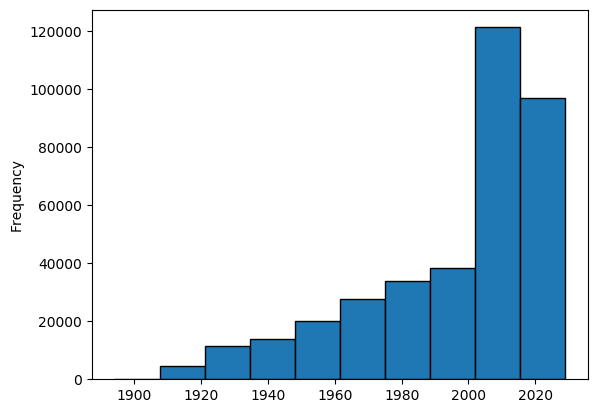

In [12]:
%matplotlib inline

#build a histogram to figure out distribution of the movie years
title_basics_processed['startYear'].plot(kind='hist', edgecolor='black')

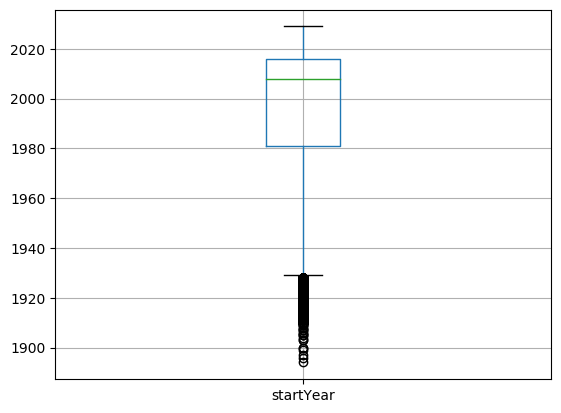

In [11]:
%matplotlib inline
# Some more detail , lets do a box plot to find the percentile distribution 
# and quartile ranges to figure out the distribution
title_basics_processed.boxplot(column='startYear', return_type='axes');

In [9]:
import numpy as np
# I want to only consider movies after 1939 and I want to remove outliers 
title_basics_processed = title_basics_processed[(title_basics_processed.startYear >= 1930) ]

#Convert year to float
title_basics_processed.startYear = title_basics_processed.startYear.apply(int)

In [10]:
import pandas as pd
title_basics_processed['runtimeMinutes'] = pd.to_numeric(title_basics_processed['runtimeMinutes'],errors='coerce')
title_basics_processed.dropna()
title_basics_processed.runtimeMinutes = title_basics_processed.runtimeMinutes.apply(int)

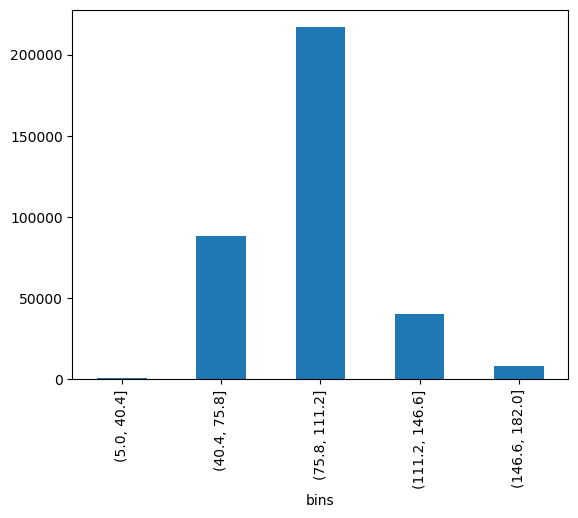

In [11]:
# lets find out what values of runTimeMins make sense to keep.
import matplotlib.pyplot as plt

# create a sample dataframe
title_basics_processed_visual = title_basics_processed

# create an array of bin edges based on runtimeMinutes. 
# start with 300 amd go until 182 
bin_edges = np.linspace(5, 182, num=6)

# create bins and assign to a new column
title_basics_processed_visual['bins'] = pd.cut(title_basics_processed_visual['runtimeMinutes'], bin_edges)

# use groupby and plot
title_basics_processed_visual.groupby('bins').size().plot(kind='bar')
plt.show()


In [12]:
# So it seems like most of the runtimeMinutes is within 182 mins
# lets get the unecessarey values out of the data set
title_basics_processed = title_basics_processed[title_basics_processed.runtimeMinutes <= 182]

In [13]:
### transform genre CSV type feature to one-hot-encoding like columns for ML usage

genre_split = list(title_basics_processed.genres)
genre_split = ','.join(genre_split)
genre_split = genre_split.split(',')
genre_split = list(set(genre_split))
for k in genre_split:
    title_basics_processed[k] = 0
    
for k in title_basics_processed.index:
    x = title_basics_processed['genres'][k].split(',')
    for j in x:
        title_basics_processed[j][k] = 1
        
title_basics_processed = title_basics_processed.drop(columns = ["bins","genres"] )
title_basics_processed.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Mystery,Comedy,Family,Talk-Show,Horror,...,Sci-Fi,Action,Animation,Game-Show,History,Documentary,Film-Noir,Thriller,Fantasy,Drama
3816,tt0003854,Dodge City Trail,Dodge City Trail,1936,56,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13082,tt0013274,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,2021,94,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15486,tt0015724,Dama de noche,Dama de noche,1993,102,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15788,tt0016029,The Little Colonel,The Little Colonel,1935,81,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17704,tt0017961,Happiness,Schaste,1935,95,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
title_basics_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354917 entries, 3816 to 9811351
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          354917 non-null  object
 1   primaryTitle    354917 non-null  object
 2   originalTitle   354917 non-null  object
 3   startYear       354917 non-null  int64 
 4   runtimeMinutes  354917 non-null  int64 
 5   Mystery         354917 non-null  int64 
 6   Comedy          354917 non-null  int64 
 7   Family          354917 non-null  int64 
 8   Talk-Show       354917 non-null  int64 
 9   Horror          354917 non-null  int64 
 10  News            354917 non-null  int64 
 11  Adult           354917 non-null  int64 
 12  Reality-TV      354917 non-null  int64 
 13  Musical         354917 non-null  int64 
 14  Biography       354917 non-null  int64 
 15  Music           354917 non-null  int64 
 16  Western         354917 non-null  int64 
 17  Romance         354917 no

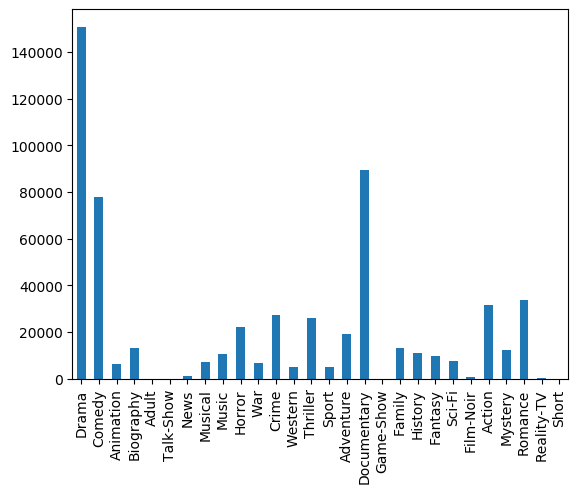

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt


title_basics_processed[['Drama','Comedy','Animation','Biography',
                        'Adult','Talk-Show','News','Musical','Music',
                       'Horror','War','Crime','Western','Thriller','Sport',
                        'Adventure','Documentary','Game-Show','Family','History',
                       'Fantasy','Sci-Fi','Film-Noir','Action','Mystery','Romance','Reality-TV','Short']].sum().plot.bar()

plt.show()

In [16]:
title_basics_processed = title_basics_processed.sort_index()
title_basics_processed

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Mystery,Comedy,Family,Talk-Show,Horror,...,Sci-Fi,Action,Animation,Game-Show,History,Documentary,Film-Noir,Thriller,Fantasy,Drama
3816,tt0003854,Dodge City Trail,Dodge City Trail,1936,56,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13082,tt0013274,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,2021,94,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15486,tt0015724,Dama de noche,Dama de noche,1993,102,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15788,tt0016029,The Little Colonel,The Little Colonel,1935,81,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17704,tt0017961,Happiness,Schaste,1935,95,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9811167,tt9916362,Coven,Akelarre,2020,92,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
9811251,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9811292,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9811319,tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,2007,100,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
title_basics_processed = title_basics_processed.drop(columns= ['Short','Reality-TV','News','Game-Show','Talk-Show','Adult'])
# title_basics_processed = title_basics_processed.drop(columns= ['index']) #no puprpose of this index , but in my case I didnt have this column, in case its there uncomment and run this
title_basics_processed.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Mystery,Comedy,Family,Horror,Musical,...,War,Sci-Fi,Action,Animation,History,Documentary,Film-Noir,Thriller,Fantasy,Drama
3816,tt0003854,Dodge City Trail,Dodge City Trail,1936,56,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13082,tt0013274,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,2021,94,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15486,tt0015724,Dama de noche,Dama de noche,1993,102,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15788,tt0016029,The Little Colonel,The Little Colonel,1935,81,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17704,tt0017961,Happiness,Schaste,1935,95,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
title_basics_processed = title_basics_processed.dropna()
# title_basics_processed.nunique(axis=0)
title_basics_processed.shape

(354917, 27)

In [19]:
# We will see how to merge the attributes of the 2 data sets to have a holistic data 
# set that we will be using going forward
# this data set has ratings and votes
title_ratings ='csv_files/title.ratings.tsv'
obj = s3.get_object(Bucket = bucket_name,Key = title_ratings)
df_title_ratings = pd.read_table(obj['Body'])
df_title_ratings.dropna()
df_title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1966
1,tt0000002,5.8,263
2,tt0000003,6.5,1808
3,tt0000004,5.6,178
4,tt0000005,6.2,2607


In [20]:
final = pd.merge(left=title_basics_processed, right=df_title_ratings, on='tconst')
final.shape

(247010, 29)

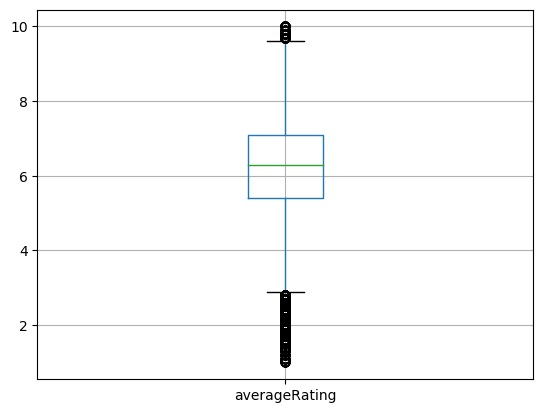

In [21]:
%matplotlib inline
final.boxplot(column='averageRating', return_type='axes');

In [22]:
# Makes sense to trim down numvotes >=5 ?
final = final[final.averageRating >= 5]
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204203 entries, 1 to 247009
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          204203 non-null  object 
 1   primaryTitle    204203 non-null  object 
 2   originalTitle   204203 non-null  object 
 3   startYear       204203 non-null  int64  
 4   runtimeMinutes  204203 non-null  int64  
 5   Mystery         204203 non-null  int64  
 6   Comedy          204203 non-null  int64  
 7   Family          204203 non-null  int64  
 8   Horror          204203 non-null  int64  
 9   Musical         204203 non-null  int64  
 10  Biography       204203 non-null  int64  
 11  Music           204203 non-null  int64  
 12  Western         204203 non-null  int64  
 13  Romance         204203 non-null  int64  
 14  Sport           204203 non-null  int64  
 15  Adventure       204203 non-null  int64  
 16  Crime           204203 non-null  int64  
 17  War       

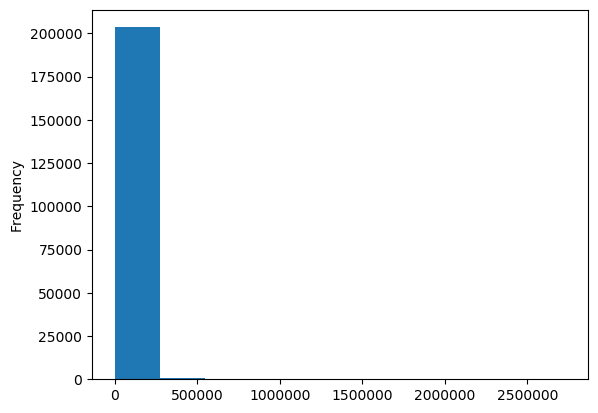

In [23]:
%matplotlib inline
final['numVotes'].plot(kind='hist')

In [24]:

final.dropna()
min_value = final['numVotes'].min()
max_value = final['numVotes'].max()
print(min_value)
print(max_value)

# print(final.info) 

5
2731760


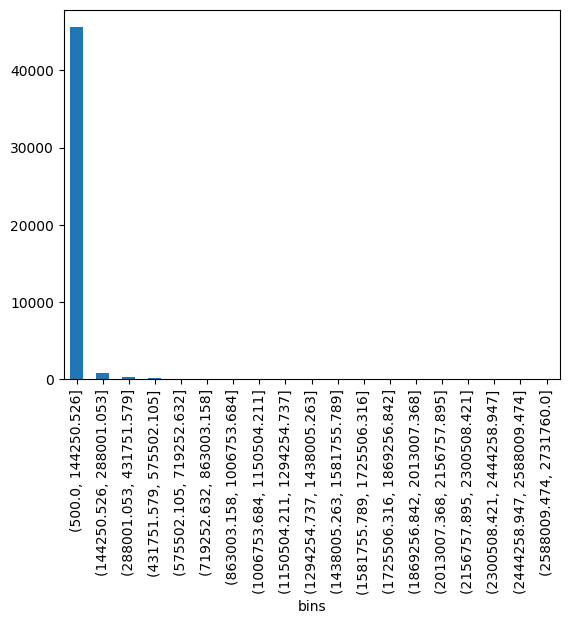

In [25]:
import matplotlib.pyplot as plt

# Lets analyze the distribution of the number of votes
# create a sample dataframe
final_visual = final

# create an array of bin edges
# 2731760,143824,33015,3672
bin_edges = np.linspace(500, 2731760, num=20)

# create bins and assign to a new column
final_visual['bins'] = pd.cut(final_visual['numVotes'], bin_edges)

# use groupby and plot
final_visual.groupby('bins').size().plot(kind='bar')
plt.show()

In [26]:
final = final[(final.numVotes >= 500) ]
final.dropna()
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47150 entries, 3 to 247008
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tconst          47150 non-null  object  
 1   primaryTitle    47150 non-null  object  
 2   originalTitle   47150 non-null  object  
 3   startYear       47150 non-null  int64   
 4   runtimeMinutes  47150 non-null  int64   
 5   Mystery         47150 non-null  int64   
 6   Comedy          47150 non-null  int64   
 7   Family          47150 non-null  int64   
 8   Horror          47150 non-null  int64   
 9   Musical         47150 non-null  int64   
 10  Biography       47150 non-null  int64   
 11  Music           47150 non-null  int64   
 12  Western         47150 non-null  int64   
 13  Romance         47150 non-null  int64   
 14  Sport           47150 non-null  int64   
 15  Adventure       47150 non-null  int64   
 16  Crime           47150 non-null  int64   
 17  War        

In [27]:
#shuffle 
final = final.sample(frac=1, random_state=42)

In [28]:
final.head()

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,Mystery,Comedy,Family,Horror,Musical,...,Animation,History,Documentary,Film-Noir,Thriller,Fantasy,Drama,averageRating,numVotes,bins
224478,tt6227192,Sexy Durga,Sexy Durga,2017,85,0,0,0,1,0,...,0,0,0,0,0,1,1,6.1,561,"(500.0, 144250.526]"
237193,tt8043092,Sammohanam,Sammohanam,2018,137,0,0,0,0,0,...,0,0,0,0,0,0,1,7.5,1987,"(500.0, 144250.526]"
32029,tt0070183,Hit!,Hit!,1973,134,0,0,0,0,0,...,0,0,0,0,0,0,1,6.0,766,"(500.0, 144250.526]"
912,tt0022386,The Sin of Madelon Claudet,The Sin of Madelon Claudet,1931,75,0,0,0,0,0,...,0,0,0,0,0,0,1,6.6,1042,"(500.0, 144250.526]"
146044,tt13985888,Miles of Love,Miles of Love,2021,135,0,1,0,0,0,...,0,0,0,0,0,0,1,5.4,989,"(500.0, 144250.526]"


In [29]:
final = final.sort_index()
final = final.reset_index()

In [30]:
final=final.drop(['index'], axis = 1)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47150 entries, 0 to 47149
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   tconst          47150 non-null  object  
 1   primaryTitle    47150 non-null  object  
 2   originalTitle   47150 non-null  object  
 3   startYear       47150 non-null  int64   
 4   runtimeMinutes  47150 non-null  int64   
 5   Mystery         47150 non-null  int64   
 6   Comedy          47150 non-null  int64   
 7   Family          47150 non-null  int64   
 8   Horror          47150 non-null  int64   
 9   Musical         47150 non-null  int64   
 10  Biography       47150 non-null  int64   
 11  Music           47150 non-null  int64   
 12  Western         47150 non-null  int64   
 13  Romance         47150 non-null  int64   
 14  Sport           47150 non-null  int64   
 15  Adventure       47150 non-null  int64   
 16  Crime           47150 non-null  int64   
 17  War         

In [31]:
# Columns to be saved for later use , since some columns are not needed for training the recommendation algorithm
movie_data = final[['tconst','primaryTitle','originalTitle']].copy()
final=final.drop(['tconst','primaryTitle','originalTitle'], axis = 1)

In [32]:
# I dont need the bins column
final = final.drop(['bins'],axis = 1)
change_column = ['startYear','runtimeMinutes','Thriller','Music','Documentary','Film-Noir','War',
                 'History','Animation','Biography','Horror','Adventure',
                 'Sport','Musical','Mystery','Action','Comedy','Sci-Fi',
                 'Crime','Romance','Fantasy','Western','Drama','Family','averageRating','numVotes']
final = final.reindex(columns=change_column)

# Check that all columns are of numeric type
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47150 entries, 0 to 47149
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startYear       47150 non-null  int64  
 1   runtimeMinutes  47150 non-null  int64  
 2   Thriller        47150 non-null  int64  
 3   Music           47150 non-null  int64  
 4   Documentary     47150 non-null  int64  
 5   Film-Noir       47150 non-null  int64  
 6   War             47150 non-null  int64  
 7   History         47150 non-null  int64  
 8   Animation       47150 non-null  int64  
 9   Biography       47150 non-null  int64  
 10  Horror          47150 non-null  int64  
 11  Adventure       47150 non-null  int64  
 12  Sport           47150 non-null  int64  
 13  Musical         47150 non-null  int64  
 14  Mystery         47150 non-null  int64  
 15  Action          47150 non-null  int64  
 16  Comedy          47150 non-null  int64  
 17  Sci-Fi          47150 non-null 

In [33]:
# End session 1 - all attributes are numerical and ready for building our models 
final.head()

,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,War,History,Animation,Biography,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
0,1935,81,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,7.0,1781
1,1935,95,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,7.3,1155
2,1930,55,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7.5,829
3,1930,73,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,7.3,3329
4,1932,101,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,7.1,3302


In [34]:
# Beginning of session 2
!pip show joblib

Name: joblib
Version: 1.2.0
Summary: Lightweight pipelining with Python functions
Home-page: https://joblib.readthedocs.io
Author: Gael Varoquaux
Author-email: gael.varoquaux@normalesup.org
License: BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: 
Required-by: nltk, scikit-learn


In [35]:
# Scaling of the final dataset
# We will be saving this model for use later on in real time predictions

from sklearn.preprocessing import StandardScaler
import joblib as joblib

# create a scaler object
column_list = list(final.columns)
print(column_list)

scaler = StandardScaler()
scaler.fit(final)
joblib.dump(scaler, 'model.joblib')


df_final_standardized = scaler.transform(final).astype(np.float32) 
# When we create the sagemaker pipeline , this should be automatically handled for us

['startYear', 'runtimeMinutes', 'Thriller', 'Music', 'Documentary', 'Film-Noir', 'War', 'History', 'Animation', 'Biography', 'Horror', 'Adventure', 'Sport', 'Musical', 'Mystery', 'Action', 'Comedy', 'Sci-Fi', 'Crime', 'Romance', 'Fantasy', 'Western', 'Drama', 'Family', 'averageRating', 'numVotes']


In [36]:
# This is where we will everything
bucket_name='awesome2023-04272023'

In [37]:
# Upload the standard scalar model to the s3 bucket
session = boto3.Session()
s3 = session.client('s3')
role = get_execution_role()
scaler_key = 'model.joblib'
s3.upload_file('model.joblib', bucket_name, scaler_key)

In [38]:
# Just for testing the output from my serialized local model i.e pkl file to see if I get back the correct responses
from pandas.io.json import json_normalize
import json
import joblib
model_trial = joblib.load("model.joblib")

print(column_list)
# JSON key/value features
# json_string = '{"startYear":[2010], "runtimeMinutes":[150], "Documentary":[0], "News":[0],"Action":[0],"Musical":[0],"Adventure":[0], "Sci-Fi":[1],"History":[0],"Mystery":[0],"Horror":[1], "Fantasy":[0],"War":[0], "Romance":[0], "Music":[0], "Biography":[0], "Sport":[0],"Drama":[1],"Western":[0], "Film-Noir": [0],"Comedy":[0], "Family":[1],"Crime":[1],"Animation":[0],"Thriller":[0],"averageRating":[5.3],"numVotes": [8000]}'


json_string = '{"startYear":[2015],"runtimeMinutes":[150],"Thriller":[1],"Music":[0],"Documentary":[0],"Film-Noir":[0],"War":[0],"History":[0],"Animation":[0],"Biography":[0],"Horror":[0],"Adventure":[1],"Sport":[0],"Musical":[0],"Mystery":[0],"Action":[1],"Comedy":[0],"Sci-Fi":[1],"Crime":[1],"Romance":[0],"Fantasy":[0],"Western":[0],"Drama":[0],"Family":[0],"averageRating":[7],"numVotes":[50]}'

# Convert the json string to a python dictionary
json_dict = json.loads(json_string)

# Normalize the json_dict to create a dataframe
json_dict_df = pd.DataFrame(json_dict)

# json_dict_df_from_model = scaler.transform(json_dict_df).astype('float32')
json_dict_df_from_model = model_trial.transform(json_dict_df).astype('float32')
json_dict_df_from_model #this is numpy array

# convert numpy array to list
json_dict_df_from_model = json_dict_df_from_model.tolist()

# convert list to json
json_response = json.dumps(json_dict_df_from_model)
respJSON = {'Output': json_response}
respJSON

['startYear', 'runtimeMinutes', 'Thriller', 'Music', 'Documentary', 'Film-Noir', 'War', 'History', 'Animation', 'Biography', 'Horror', 'Adventure', 'Sport', 'Musical', 'Mystery', 'Action', 'Comedy', 'Sci-Fi', 'Crime', 'Romance', 'Fantasy', 'Western', 'Drama', 'Family', 'averageRating', 'numVotes']


{'Output': '[[0.7641384601593018, 2.2621326446533203, 2.6349685192108154, -0.19743624329566956, -0.27217793464660645, -0.10682649910449982, -0.17017419636249542, -0.20378568768501282, -0.18412098288536072, -0.2402506023645401, -0.29970091581344604, 3.0483622550964355, -0.14215995371341705, -0.14177125692367554, -0.27615731954574585, 2.3601934909820557, -0.7180797457695007, 5.349470615386963, 2.2987284660339355, -0.46801629662513733, -0.22049188613891602, -0.1328728199005127, -1.1882809400558472, -0.21341808140277863, 0.5960079431533813, -0.24598699808120728]]'}

In [39]:
# Look all values are along the same scale now.
df_final_standardized = pd.DataFrame(df_final_standardized)
df_final_standardized.columns = column_list
df_final_standardized.head()

,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,War,History,Animation,Biography,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
0,-2.696403,-1.132088,-0.379511,5.064926,-0.272178,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,1.392603,-0.186934,-0.435023,-0.468016,-0.220492,-0.132873,-1.188281,4.685638,0.596008,-0.225267
1,-2.696403,-0.443406,-0.379511,-0.197436,-0.272178,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,1.392603,-0.186934,-0.435023,-0.468016,-0.220492,-0.132873,0.841552,-0.213418,0.970587,-0.232760
2,-2.912687,-2.411070,-0.379511,-0.197436,3.674067,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,-0.718080,-0.186934,-0.435023,-0.468016,-0.220492,-0.132873,-1.188281,-0.213418,1.220306,-0.236662
3,-2.912687,-1.525621,-0.379511,-0.197436,-0.272178,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,1.392603,-0.186934,-0.435023,2.136678,-0.220492,-0.132873,0.841552,-0.213418,0.970587,-0.206737
4,-2.826174,-0.148256,-0.379511,-0.197436,-0.272178,-0.106826,-0.170174,-0.203786,-0.184121,-0.240251,...,-0.718080,-0.186934,-0.435023,-0.468016,-0.220492,-0.132873,0.841552,-0.213418,0.720868,-0.207060


In [40]:
# #this will train on the data set that we have , to find clusters. Epoch is the number of iterations
# #this will take time , so for saving time we will reuse the training output from a previous run which was used
# #to find the ideal number of clusters

# from time import gmtime, strftime
# from sagemaker import KMeans
# output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
# output_folder = 'KMeans-results-v2-' + output_time
# K = range(2, 51) # change the range to be used for k
# job_names = []

# # launching jobs for all k
# for k in K:
#     print('starting train job for cluster with k:' + str(k))
#     output_location = 's3://{}/kmeans_movieoutput/'.format(bucket_name) + output_folder
#     print('training artifacts will be uploaded to: {}'.format(output_location))
#     job_name = 'movierecommender-2023-' + str(k)
    
#     kmeans = KMeans(role=role, instance_count=1, instance_type='ml.c4.xlarge', init_method='kmeans++', 
#                 output_path=output_location, k=k, epochs=5) 
#     kmeans.fit(kmeans.record_set(df_final_standardized.values), job_name=job_name)
    
#     job_names.append(job_name)
#     print('end of train job for cluster: ' + str(k))

In [41]:
#Apache deep learning library , helps in visualizing the distortion graph
!pip install mxnet
print(bucket_name)


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
awesome2023-04272023


kmeans_movieoutput/KMeans-results-v2-2023-04-29-05-22-28/movierecommender-2023-2/output/model.tar.gz
Model for k=2 (kmeans_movieoutput/KMeans-results-v2-2023-04-29-05-22-28/movierecommender-2023-2/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-04-29-05-22-28/movierecommender-2023-3/output/model.tar.gz
Model for k=3 (kmeans_movieoutput/KMeans-results-v2-2023-04-29-05-22-28/movierecommender-2023-3/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-04-29-05-22-28/movierecommender-2023-4/output/model.tar.gz
Model for k=4 (kmeans_movieoutput/KMeans-results-v2-2023-04-29-05-22-28/movierecommender-2023-4/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-04-29-05-22-28/movierecommender-2023-5/output/model.tar.gz
Model for k=5 (kmeans_movieoutput/KMeans-results-v2-2023-04-29-05-22-28/movierecommender-2023-5/output/model.tar.gz)
model_algo-1
kmeans_movieoutput/KMeans-results-v2-2023-04-29-05-22-28/movierecommender-20

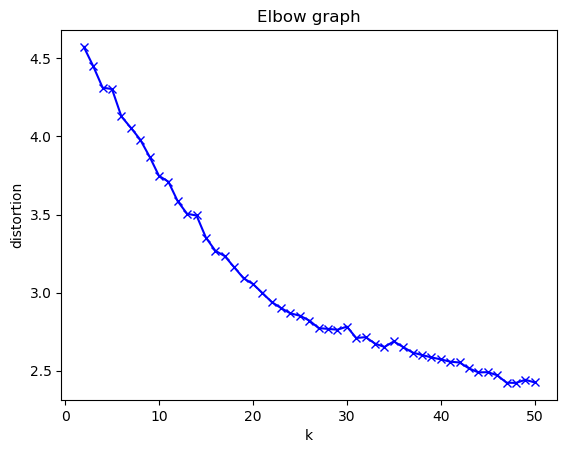

In [42]:
#use already trained models in s3 to find what is the appropriate number of clusters
#need to use a different way to find the elbow graph of a sagemaker trained kmeans model as opposed to
#sklearn k means
import mxnet as mx
from scipy.spatial.distance import cdist
markers = ['o', 'v', 's']
models = {}
distortions = []
output_folder = 'kmeans_movieoutput/';
result_folder = 'KMeans-results-v2-2023-04-29-05-22-28/'
final_folder ='movierecommender-2023-'
K = range(2, 51) # change the range to be used for k
for k in K:
    s3_client = boto3.client('s3')
    key = output_folder + result_folder + final_folder+str(k) +  '/output/model.tar.gz'
    print(key)
    s3_client.download_file(bucket_name, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar --no-same-owner -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(df_final_standardized.values, kmeans_numpy, 'euclidean'), axis=1)) / df_final_standardized.values.shape[0])
    models[k] = kmeans_numpy
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('distortion')
plt.title('Elbow graph')
plt.show()

In [43]:
#above steps were done to find the optimal number of clusters.
#once that is known , I train the model for k=25 and then deploy the model

from sagemaker import KMeans
kmeans = KMeans(role=role,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name + '/',
                init_method='kmeans++',
                k=23, 
                epochs=5)
kmeans.fit(kmeans.record_set(df_final_standardized.values))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2023-04-29-14-15-10-826


2023-04-29 14:15:15 Starting - Starting the training job...
2023-04-29 14:15:40 Starting - Preparing the instances for training......
2023-04-29 14:16:28 Downloading - Downloading input data...
2023-04-29 14:16:59 Training - Downloading the training image......
2023-04-29 14:18:09 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/29/2023 14:18:16 INFO 139758454757184] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '

In [46]:
#deploy a trained model
#After executing this cell the Kmeans model will be deployed

kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2023-04-29-14-42-12-022
INFO:sagemaker:Creating endpoint-config with name kmeans-2023-04-29-14-42-12-022
INFO:sagemaker:Creating endpoint with name kmeans-2023-04-29-14-42-12-022


------!

In [47]:
df_final_standardized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47150 entries, 0 to 47149
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startYear       47150 non-null  float32
 1   runtimeMinutes  47150 non-null  float32
 2   Thriller        47150 non-null  float32
 3   Music           47150 non-null  float32
 4   Documentary     47150 non-null  float32
 5   Film-Noir       47150 non-null  float32
 6   War             47150 non-null  float32
 7   History         47150 non-null  float32
 8   Animation       47150 non-null  float32
 9   Biography       47150 non-null  float32
 10  Horror          47150 non-null  float32
 11  Adventure       47150 non-null  float32
 12  Sport           47150 non-null  float32
 13  Musical         47150 non-null  float32
 14  Mystery         47150 non-null  float32
 15  Action          47150 non-null  float32
 16  Comedy          47150 non-null  float32
 17  Sci-Fi          47150 non-null 

In [48]:
prediction_data1 = df_final_standardized[0:40000]
prediction_data2 = df_final_standardized[40000:47150]

result1=kmeans_predictor.predict(prediction_data1.values)
result2=kmeans_predictor.predict(prediction_data2.values)

result = result1 + result2 

In [51]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
predictions = pd.DataFrame(data=cluster_labels)

In [52]:
predictions.info

<bound method DataFrame.info of           0
0      10.0
1       9.0
2       3.0
3       9.0
4       9.0
...     ...
47145  20.0
47146  12.0
47147  12.0
47148   4.0
47149  22.0

[47150 rows x 1 columns]>

In [53]:
column_list

['startYear',
 'runtimeMinutes',
 'Thriller',
 'Music',
 'Documentary',
 'Film-Noir',
 'War',
 'History',
 'Animation',
 'Biography',
 'Horror',
 'Adventure',
 'Sport',
 'Musical',
 'Mystery',
 'Action',
 'Comedy',
 'Sci-Fi',
 'Crime',
 'Romance',
 'Fantasy',
 'Western',
 'Drama',
 'Family',
 'averageRating',
 'numVotes']

In [54]:
#this pred_final data needs to be saved so that it can be used for lookup during real time predictions
pred_info = pd.concat([predictions, final], axis=1)
pred_info = pred_info.rename(columns={0: 'cluster'})
pred_final = pd.concat([movie_data, pred_info], axis=1)
pred_final

,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
0,tt0016029,The Little Colonel,The Little Colonel,10.0,1935,81,0,1,0,0,...,1,0,0,0,0,0,0,1,7.0,1781
1,tt0017961,Happiness,Schaste,9.0,1935,95,0,0,0,0,...,1,0,0,0,0,0,1,0,7.3,1155
2,tt0019403,Salt for Svanetia,Jim Shvante (marili svanets),3.0,1930,55,0,0,1,0,...,0,0,0,0,0,0,0,0,7.5,829
3,tt0020163,People on Sunday,Menschen am Sonntag,9.0,1930,73,0,0,0,0,...,1,0,0,1,0,0,1,0,7.3,3329
4,tt0020298,Queen Kelly,Queen Kelly,9.0,1932,101,0,0,0,0,...,0,0,0,0,0,0,1,0,7.1,3302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47145,tt9907782,The Cursed,Eight for Silver,20.0,2021,111,0,0,0,0,...,0,0,0,0,1,0,0,0,6.2,12808
47146,tt9908390,Le lion,Le lion,12.0,2020,95,0,0,0,0,...,1,0,0,0,0,0,0,0,5.4,1285
47147,tt9911196,The Marriage Escape,De beentjes van Sint-Hildegard,12.0,2020,103,0,0,0,0,...,1,0,0,0,0,0,1,0,7.5,2890
47148,tt9916270,Il talento del calabrone,Il talento del calabrone,4.0,2020,84,1,0,0,0,...,0,0,0,0,0,0,0,0,5.8,1418


In [55]:
#Lets test with real data in our Notebook....
data_to_predict1 = {"startYear":[2015], "runtimeMinutes":[150],"Thriller":[1],"Music":[0],"Documentary":[0],
                    "Film-Noir":[0],"War":[0],"History":[0],"Animation":[0],"Biography":[0],
                    "Horror":[0],"Adventure":[0],"Sport":[0],"Musical":[0],
                    "Mystery":[0],"Action":[0],"Comedy":[0],"Sci-Fi":[1],
                    "Crime":[0],"Romance":[0],"Fantasy":[0],"Western":[0],
                    "Drama":[0],"Family":[0],
                    "averageRating":[7],"numVotes":[50]}

in_data2 = pd.DataFrame(data_to_predict1)
input2 = scaler.transform(in_data2).astype('float32')
print(type(input2))
print(input2.ndim)
print(input2)
input2_pred = kmeans_predictor.predict(input2)
input2_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in input2_pred]
#predicted cluster 
print(int(input2_cluster[0]))

<class 'numpy.ndarray'>
2
[[ 0.76413846  2.2621326   2.6349685  -0.19743624 -0.27217793 -0.1068265
  -0.1701742  -0.20378569 -0.18412098 -0.2402506  -0.29970092 -0.328045
  -0.14215995 -0.14177126 -0.27615732 -0.4236941  -0.71807975  5.3494706
  -0.4350231  -0.4680163  -0.22049189 -0.13287282 -1.1882809  -0.21341808
   0.59600794 -0.245987  ]]
21


In [56]:
recommendations = pred_final.loc[pred_final['cluster'] == 
            int(input2_cluster[0])].sort_values(by =['averageRating', 'numVotes'], ascending=False)[:10]
recommendations

,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
29149,tt12820524,Helsreach: The Movie,Helsreach: The Movie,21.0,2019,150,0,0,0,0,...,0,1,0,0,0,0,0,0,9.0,1116
33433,tt1795369,Frankenstein,National Theatre Live: Frankenstein,21.0,2011,130,0,0,0,0,...,0,1,0,0,0,0,1,0,8.6,3976
18652,tt0252196,Aditya 369,Aditya 369,21.0,1991,140,0,0,0,0,...,1,1,0,0,0,0,0,0,8.5,3193
41243,tt4983780,Maanaadu,Maanaadu,21.0,2021,147,0,0,0,0,...,0,1,0,0,0,0,0,0,8.3,23691
36100,tt2358592,Lucia,Lucia,21.0,2013,135,1,0,0,0,...,0,1,0,0,0,0,1,0,8.3,12656
43412,tt6332276,What We Left Behind: Looking Back at Star Trek...,What We Left Behind: Looking Back at Star Trek...,21.0,2018,116,0,0,1,0,...,0,1,0,0,0,0,0,0,8.3,1988
29011,tt12706382,Siren Head,Siren head,21.0,2020,52,1,0,0,0,...,0,1,0,0,0,0,0,0,8.3,1311
10385,tt0084787,The Thing,The Thing,21.0,1982,109,0,0,0,0,...,0,1,0,0,0,0,0,0,8.2,436309
7899,tt0070233,Ivan Vasilyevich Changes His Profession,Ivan Vasilevich menyaet professiyu,21.0,1973,88,0,0,0,0,...,1,1,0,0,0,0,0,0,8.2,17364
32515,tt1652415,Condition,Condition,21.0,2011,70,0,0,0,0,...,0,1,0,0,0,0,1,0,8.2,525


In [57]:
# Now perform the steps for using the sagemaker migration toolkit in your Cloud 9 environment to deploy the sklearn scaling model to sagemaker.
# After the sklearn custom model is deployed to sagemaker , we can come back and execute the below cell to execute 
# the 2 deployed model endpoints one after another and find the predicted cluster.

In [58]:
#Finally we will seee what movies are a part of that cluster that has been returned.

import boto3
import json
import numpy as np

# Create a SageMaker runtime client
client = boto3.client('runtime.sagemaker')

# Define the endpoint name and the json structure to pass to it
endpoint_name = 'sm-endpoint-sklearn-2023-04-29-13-00-57'
json_structure = {"startYear":[2015], "runtimeMinutes":[150],"Thriller":[1],"Music":[0],"Documentary":[0],
                    "Film-Noir":[0],"War":[0],"History":[0],"Animation":[0],"Biography":[0],
                    "Horror":[0],"Adventure":[0],"Sport":[0],"Musical":[0],
                    "Mystery":[0],"Action":[0],"Comedy":[0],"Sci-Fi":[1],
                    "Crime":[0],"Romance":[0],"Fantasy":[0],"Western":[0],
                    "Drama":[0],"Family":[0],
                    "averageRating":[7],"numVotes":[50]}


# Convert the json structure to a bytes object
payload = json.dumps(json_structure).encode('utf-8')

# Invoke the endpoint and get the response
response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=payload)

# Get the response body
response_body = response['Body'].read().decode('utf-8')

string_array = json.loads(response_body)["Output"]
np_array = np.fromstring(string_array.replace("[", "").replace("]", ""), sep=",")

arr_2d = np.reshape(np_array, (1, len(np_array)))

print(arr_2d.astype('float32'))
print(type(arr_2d))
print(arr_2d.ndim)

test_predictions = kmeans_predictor.predict(arr_2d.astype('float32'))
returned_cluster = [r.label['closest_cluster'].float32_tensor.values[0] for r in test_predictions]
#predicted cluster 
print(int(returned_cluster[0]))

recommendations_sagemaker_models = pred_final.loc[pred_final['cluster'] == 
            int(returned_cluster[0])].sort_values(by =['averageRating', 'numVotes'], ascending=False)[:10]
recommendations_sagemaker_models


[[ 0.76413846  2.2621326   2.6349685  -0.19743624 -0.27217793 -0.1068265
  -0.1701742  -0.20378569 -0.18412098 -0.2402506  -0.29970092 -0.328045
  -0.14215995 -0.14177126 -0.27615732 -0.4236941  -0.71807975  5.3494706
  -0.4350231  -0.4680163  -0.22049189 -0.13287282 -1.1882809  -0.21341808
   0.59600794 -0.245987  ]]
<class 'numpy.ndarray'>
2
21


,tconst,primaryTitle,originalTitle,cluster,startYear,runtimeMinutes,Thriller,Music,Documentary,Film-Noir,...,Comedy,Sci-Fi,Crime,Romance,Fantasy,Western,Drama,Family,averageRating,numVotes
29149,tt12820524,Helsreach: The Movie,Helsreach: The Movie,21.0,2019,150,0,0,0,0,...,0,1,0,0,0,0,0,0,9.0,1116
33433,tt1795369,Frankenstein,National Theatre Live: Frankenstein,21.0,2011,130,0,0,0,0,...,0,1,0,0,0,0,1,0,8.6,3976
18652,tt0252196,Aditya 369,Aditya 369,21.0,1991,140,0,0,0,0,...,1,1,0,0,0,0,0,0,8.5,3193
41243,tt4983780,Maanaadu,Maanaadu,21.0,2021,147,0,0,0,0,...,0,1,0,0,0,0,0,0,8.3,23691
36100,tt2358592,Lucia,Lucia,21.0,2013,135,1,0,0,0,...,0,1,0,0,0,0,1,0,8.3,12656
43412,tt6332276,What We Left Behind: Looking Back at Star Trek...,What We Left Behind: Looking Back at Star Trek...,21.0,2018,116,0,0,1,0,...,0,1,0,0,0,0,0,0,8.3,1988
29011,tt12706382,Siren Head,Siren head,21.0,2020,52,1,0,0,0,...,0,1,0,0,0,0,0,0,8.3,1311
10385,tt0084787,The Thing,The Thing,21.0,1982,109,0,0,0,0,...,0,1,0,0,0,0,0,0,8.2,436309
7899,tt0070233,Ivan Vasilyevich Changes His Profession,Ivan Vasilevich menyaet professiyu,21.0,1973,88,0,0,0,0,...,1,1,0,0,0,0,0,0,8.2,17364
32515,tt1652415,Condition,Condition,21.0,2011,70,0,0,0,0,...,0,1,0,0,0,0,1,0,8.2,525


In [ ]:
# We do the steps below, so that the dataframe "pred_final" holding the final predictions is saved to a persistent database, for quick lookup by our API's
# The AWS Service used for this purpose is Glue and will represent the schema of the final predictions 
# Additionally in the below steps we will be saving the data in S3 in a highly compressed format called parquet

In [65]:
!pip install awswrangler


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [66]:
# Execution role is arn:aws:sts::XXXX:assumed-role/AmazonSageMaker-ExecutionRole-XXXX/SageMaker
# This role needs glue:CreateTable action -> AWSGlueServiceRole. If the role doesnt have the policy please add it to the Role.
# Change bucket name below
import awswrangler as wr
wr.s3.to_parquet(
    df=pred_final,
    path="s3://awesome2023-04272023/clusteredfinaldata/",
    dataset=True,
    database="default",
    table="clusters"
);

In [67]:
col_names = ["tconst", "primarytitle", "originaltitle", "cluster", "startyear", "runtimeminutes", "thriller", "music",
            "documentary","film_noir","war","history","animation","biography","horror","adventure","sport","musical","mystery",
            "action","comedy","sci_fi","crime","romance","fantasy","western","drama","family","averagerating","numvotes"]


sql = """
SELECT
    *
FROM clusters
WHERE cluster =:x; order by averagerating , numvotes asc limit 10
"""

# df = wr.athena.read_sql_query(sql, params={"x": result['predictions'][0]['closest_cluster']} , database="default")
df = wr.athena.read_sql_query(sql, params={"x": 5} , database="default")

In [68]:
df

,tconst,primarytitle,originaltitle,cluster,startyear,runtimeminutes,thriller,music,documentary,film_noir,...,comedy,sci_fi,crime,romance,fantasy,western,drama,family,averagerating,numvotes
0,tt0026614,Lawless Range,Lawless Range,5.0,1935,53,0,0,0,0,...,0,0,0,0,0,1,1,0,5.0,525
1,tt0120121,The Shooter,The Shooter,5.0,1997,91,0,0,0,0,...,0,0,0,0,0,1,0,0,5.0,686
2,tt0067870,A Town Called Hell,A Town Called Bastard,5.0,1971,95,0,0,0,0,...,0,0,0,0,0,1,1,0,5.0,776
3,tt4746102,The Scent of Rain & Lightning,The Scent of Rain & Lightning,5.0,2017,100,0,0,0,0,...,0,0,0,0,0,1,1,0,5.0,923
4,tt0027087,Texas Terror,Texas Terror,5.0,1935,51,0,0,0,0,...,0,0,0,0,0,1,0,0,5.0,1015
5,tt0025373,The Lawless Frontier,The Lawless Frontier,5.0,1934,59,0,0,0,0,...,0,0,0,0,0,1,0,0,5.0,1075
6,tt5255524,Traded,Traded,5.0,2016,98,0,0,0,0,...,0,0,0,0,0,1,0,0,5.0,2744
7,tt0903131,All Hat,All Hat,5.0,2007,89,0,0,0,0,...,0,0,0,0,0,1,0,0,5.1,572
8,tt0082193,Comin' at Ya!,Comin' at Ya!,5.0,1981,91,0,0,0,0,...,0,0,0,0,0,1,0,0,5.1,601
9,tt8770976,Savage State,L'état sauvage,5.0,2019,121,0,0,0,0,...,0,0,0,0,0,1,1,0,5.1,696


In [69]:
# After the above steps are done, follow the steps in main README to create the REST API gateway and lambda API's 
# that will invoke the sagemaker endpoints to get the correct cluster and then get the relevant movies belonging to that cluster 
# from the glue database.